In [13]:
import tensorflow as tf
import numpy as np
import pathlib
import matplotlib.pyplot as plt
import os
from matplotlib import lines

In [14]:
def get_labels():
    return [
        'Achaemenid architecture',
        'American craftsman style',
        'American Foursquare architecture',
        'Ancient Egyptian architecture',
        'Art Deco architecture',
        'Art Nouveau architecture',
        'Baroque architecture',
        'Bauhaus architecture',
        'Beaux-Arts architecture',
        'Byzantine architecture',
        'Chicago school architecture',
        'Colonial architecture',
        'Deconstructivism',
        'Edwardian architecture',
        'Georgian architecture',
        'Gothic architecture',
        'Greek Revival architecture',
        'International style',
        'Novelty architecture',
        'Palladian architecture',
        'Postmodern architecture',
        'Queen Anne architecture',
        'Romanesque architecture',
        'Russian Revival architecture',
        'Tudor Revival architecture',
    ]
    
def get_labels_translated():
    return [
        'Achemenidų architektūra',
        'Amerikietiško meistro stilius',
        'Amerikietiška Foursquare architektūra',
        'Senovės Egipto architektūra',
        'Art Deco architektūra',
        'Moderno architektūra',
        'Baroko architektūra',
        'Bauhaus architektūra',
        'Beaux-Arts architektūra',
        'Bizantijos architektūra',
        'Čikagos mokyklos architektūra',
        'Kolonijinė architektūra',
        'Dekonstruktyvizmas',
        'Edvardo architektūra',
        'Gruzijos architektūra',
        'Gotikinė architektūra',
        'Graikijos atgimimo architektūra',
        'Tarptautinis stilius',
        'Naujovinė architektūra',
        'Paladianizmas',
        'Postmodernioji architektūra',
        'Karalienės Anos architektūra',
        'Romanika',
        'Rusijos atgimimo architektūra',
        'Tiudorų atgimimo architektūra',
    ]

class ModelTester:
    img_shape = None
    test_dataset = None
    class_names = None
    class_names_translated = None
    num_classes = None
    batch_size = 4
    model = None
    data_dir = None
    model_dir = None

    def __init__(self, data_dir: str, validation_split: float, model_dir: str):
        self.data_dir = pathlib.Path(data_dir)
        img_count = len(list(self.data_dir.glob('*/*.*')))
        val_size = int(img_count * validation_split)
        self.model: tf.keras.Model = tf.keras.models.load_model(model_dir)
        self.model_dir = model_dir
        print("model input shape:", self.model.input_shape)
        
        self.class_names = np.array(
            sorted([item.name for item in self.data_dir.glob('*') if item.is_dir()])
        )
        self.num_classes = len(self.class_names)
        
        self.class_names_translated = []
        labels = get_labels()
        labels_translated = get_labels_translated()
        for label in self.class_names:
            self.class_names_translated.append(
                labels_translated[labels.index(label)]
            )
        
        self.img_shape = self.model.input_shape[1:3]

        dataset: tf.data.Dataset = tf.data.Dataset.list_files(str(self.data_dir/'*/*'), shuffle=False)
        dataset: tf.data.Dataset = dataset.shuffle(buffer_size=img_count, reshuffle_each_iteration=False, seed=1337)

        self.test_dataset = dataset.skip(int(val_size / 2)).take(int(val_size / 2))
        self.test_dataset = self.test_dataset.map(self.load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
        self.test_dataset = self.test_dataset.batch(self.batch_size).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
        
        print("loaded", self.test_dataset.cardinality().numpy() * self.batch_size, "images")

    def get_test_dataset(self):
        return self.test_dataset

    def plot_training_loss(self, history_path: str, history_fine_tune_path: str):
        history: dict = np.load(history_path, allow_pickle=True).item()
        history_fine_tune: dict = np.load(history_fine_tune_path, allow_pickle=True).item()
        
        fine_tuning_starting_point = len(history['loss']) - 5
        
        combined_loss: list = history['loss']
        for _ in range(5):
            combined_loss.pop()
        combined_loss.extend(history_fine_tune['loss'])
        for _ in range(5):
            combined_loss.pop()
        
        combined_val_loss = history['val_loss']
        for _ in range(5):
            combined_val_loss.pop()
        combined_val_loss.extend(history_fine_tune['val_loss'])
        for _ in range(5):
            combined_val_loss.pop()
        

        x = range(1, len(combined_loss) + 1)
        
        plt.plot(x, combined_val_loss, 'b-', label="Validacijos nuostolis")
        plt.plot(x, combined_loss, 'r--', label="Treniravimo nuostolis")
        plt.axvline(fine_tuning_starting_point, color="green", label="Adaptavimo pradžia", linestyle=":")
        plt.title("Modelio treniravimo nuostolio rezultatai")
        plt.xlabel("Epochos")
        plt.ylabel("Nuostolis")
        plt.grid(True)
        plt.legend()

        plt.savefig(self.model_dir + '/plot_loss.jpg')
        plt.show()
        
        print("Validacijos nuostolis: ", combined_val_loss[-1])
        print("Treniravimo nuostolis: ", combined_loss[-1])
        
    def plot_training_accuracy(self, history_path: str, history_fine_tune_path: str):
        history: dict = np.load(history_path, allow_pickle=True).item()
        history_fine_tune: dict = np.load(history_fine_tune_path, allow_pickle=True).item()
        
        fine_tuning_starting_point = len(history['accuracy']) - 5
        
        combined_loss: list = history['accuracy']
        for _ in range(5):
            combined_loss.pop()
        combined_loss.extend(history_fine_tune['accuracy'])
        for _ in range(5):
            combined_loss.pop()
        
        combined_val_loss = history['val_accuracy']
        for _ in range(5):
            combined_val_loss.pop()
        combined_val_loss.extend(history_fine_tune['val_accuracy'])
        for _ in range(5):
            combined_val_loss.pop()
        

        x = range(1, len(combined_loss) + 1)
        
        plt.plot(x, combined_val_loss, 'b-', label="Validacijos tikslumas")
        plt.plot(x, combined_loss, 'r--', label="Treniravimo tikslumas")
        plt.axvline(fine_tuning_starting_point, color="green", label="Adaptavimo pradžia", linestyle=":")
        plt.title("Modelio treniravimo tikslumo rezultatai")
        plt.xlabel("Epochos")
        plt.ylabel("Tikslumas")
        plt.grid(True)
        plt.legend()

        plt.savefig(self.model_dir + '/plot_acc.jpg')
        plt.show()
        
        print("Validacijos tikslumas: ", combined_val_loss[-1])
        print("Treniravimo tikslumas: ", combined_loss[-1])

    def get_label(self, file_path):
        parts = tf.strings.split(file_path, os.path.sep)
        one_hot = parts[-2] == self.class_names
        return one_hot

    def load_image(self, file_path):
        label = self.get_label(file_path)
        img = tf.io.read_file(file_path)
        img = tf.io.decode_jpeg(img, channels=3)
        img = tf.image.resize(img, self.img_shape)
        img = tf.cast(img, dtype=tf.uint8)
        return img, label

    def predict_test(self):
        return self.model.predict(self.test_dataset)

    def plot_prediction(self, image, label, prediction):
        plt.figure()
        f, xarr = plt.subplots(2, 1)
        xarr[0].imshow(image.numpy())
        xarr[1].plot(prediction)
        xarr[1].grid(True, axis="x")
        xarr[1].add_line(lines.Line2D((label.numpy(), label.numpy()), (0, 1)))
        plt.xticks(range(25))
        plt.show()
        plt.close()

    def is_in_top_x(self, prediction, label, x):
        pred_labels = range(25)
        prediction, pred_labels = zip(*sorted(zip(prediction, pred_labels)))

        top_labels = tuple(reversed(pred_labels))[0:x]

        if label in top_labels:
            return True

        return False

    def get_predicted_class(self, results):
        predicted_class = 0
        predicted_certainty = 0.0
        for i, _ in enumerate(results):
            if results[i] > predicted_certainty:
                predicted_class = i
                predicted_certainty = results[i]

        return predicted_class, predicted_certainty

    def test_accuracy(self, prediction, dataset: tf.data.Dataset):
        correct_predictions = 0
        correct_predictions_top_3 = 0
        for (p, (_, label)) in zip(prediction, dataset.unbatch()):
            predicted = self.get_predicted_class(p)

            if len(label.numpy()) > 1:
                for i, x in enumerate(label.numpy()):
                    if x == True:
                        label = i
            else:
                label = label.numpy()
            
            if predicted[0] == label:
                correct_predictions += 1

            if self.is_in_top_x(p, label, 5):
                correct_predictions_top_3 += 1

        print("Accuracy: ", int(correct_predictions / len(prediction) * 10000) / 100)
        print("Top 5 accuracy: ", int(correct_predictions_top_3 / len(prediction) * 10000) / 100)
        
    def test_f1_score(self, prediction, dataset: tf.data.Dataset):
        f1_stats = []
        
        confusion_matrix = self.create_confusion_matrix(
            self.categorize_results_by_label(prediction, dataset)
        )
        
        labels = get_labels()
        
        for classification in range(confusion_matrix.shape[0]):
            true_positives = confusion_matrix[classification, classification]
            false_positives = np.sum(confusion_matrix[classification, :]) - true_positives
            false_negatives = np.sum(confusion_matrix[:, classification]) - true_positives

            stats = dict()
            precision = true_positives / (true_positives + false_positives)
            recall = true_positives / (true_positives + false_negatives)
            stats['class'] = labels[classification]
            stats['f1_score'] = (2 * precision * recall) / (precision + recall)
            stats['precision'] = precision
            stats['recall'] = recall
            stats['pred_count'] = np.sum(confusion_matrix[classification, :])

            f1_stats.append(stats)
            
        return f1_stats

    def categorize_results_by_label(self, prediction: dict, dataset: tf.data.Dataset):
        results_by_label = dict()

        for label in self.class_names:
            results_by_label[label] = list()
            
        for (certainty_list, (image, label_index)) in zip(prediction, dataset.unbatch()):
            if len(label_index.numpy()) > 1:
                for i, x in enumerate(label_index.numpy()):
                    if x == True:
                        label_index = i
            result = dict()
            
            result['prediction_array'] = certainty_list
            result['prediction_index'] = int(self.get_predicted_class(certainty_list)[0])
            result['prediction_label'] = self.class_names[self.get_predicted_class(certainty_list)[0]]
            result['prediction_certainty'] = self.get_predicted_class(certainty_list)[1]
            result['image'] = image
            result['correct_index'] = int(label_index)
            result['correct_label'] = self.class_names[label_index]
            
            results_by_label[result['correct_label']].append(result)
                    
        return results_by_label
    
    def group_missed_results(self, results_by_label):
        missed_predictions = []
        for index, (label, results) in enumerate(results_by_label.items()):
            for result in results:
                if result['correct_index'] != result['prediction_index']:
                    missed_predictions.append(result)
        
        return missed_predictions
    
    def create_confusion_matrix(self, results_by_label):
        confusion_matrix = np.zeros((self.num_classes, self.num_classes), float)

        for index, (label, results) in enumerate(results_by_label.items()):
            for result in results:
                confusion_matrix[index, result['prediction_index']] += 1
        
        return confusion_matrix
    
    def create_confusion_matrix_percentage(self, results_by_label):
        confusion_matrix = np.zeros((self.num_classes, self.num_classes), float)

        for index, (label, results) in enumerate(results_by_label.items()):
            inc = 1 / len(results)
            for result in results:
                confusion_matrix[index, result['prediction_index']] += inc

        for x in range(self.num_classes):
            for y in range(self.num_classes):
                confusion_matrix[x, y] = int(confusion_matrix[x, y] * 100) / 100
                
        return confusion_matrix

    def plot_confusion_matrix(self, results_by_label: dict):
        import pandas as pd
        import seaborn as sn
        confusion_matrix = self.create_confusion_matrix_percentage(results_by_label)

        df = pd.DataFrame(confusion_matrix, index=[i for i in self.class_names_translated], columns=[i for i in self.class_names_translated])
        
        sn.set(font_scale=1.1)
        plt.figure(figsize=(20, 18))
        plt.title("Sumaišymo matrica")
        sn.heatmap(df, annot=True, vmin=0.0, vmax=1.0, cbar=True, annot_kws={"size": 11})
        plt.savefig('./' + str(self.model_dir) + ' confusion matrix.jpg')
        plt.show()
        plt.close()
        
        return confusion_matrix
    
    def get_y_true(self):
        y_true = list()

        for _image, label_index in self.test_dataset.unbatch():
            for i, x in enumerate(label_index.numpy()):
                if x == True:
                    label_index = i

            one_hot = np.zeros((25))
            one_hot[int(label_index)] = 1
            y_true.append(one_hot)
        return np.array(y_true)


In [15]:
MODEL_DIR = "model"
DATA_DIR = "balanced_dataset"
tester = ModelTester(DATA_DIR, 0.2, MODEL_DIR + '/final')

model input shape: (None, 224, 224, 3)
loaded 568 images


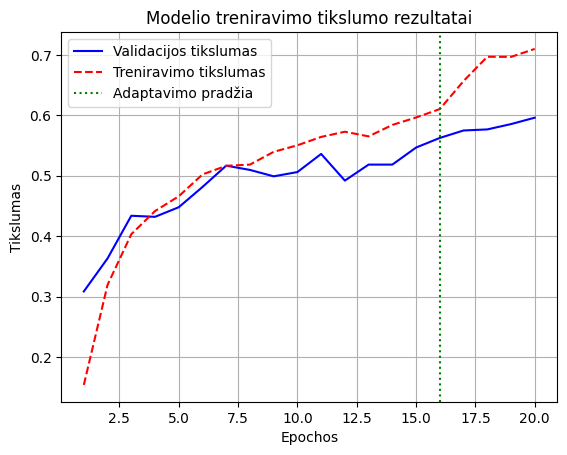

Validacijos tikslumas:  0.5961199402809143
Treniravimo tikslumas:  0.7099118828773499


In [ ]:
tester.plot_training_accuracy(MODEL_DIR + "/history.npy", MODEL_DIR + "/history_fine_tune.npy")

In [ ]:
tester.plot_training_loss(MODEL_DIR + "/history.npy", MODEL_DIR + "/history_fine_tune.npy")

Validacijos nuostolis:  1.2776532173156738
Treniravimo nuostolis:  0.8777909874916077


In [16]:
prediction = tester.predict_test()

142/142 [==============================] - 14s 94ms/step


In [11]:
f1_stats = tester.test_f1_score(prediction, tester.test_dataset)

In [112]:
# for stat in f1_stats:
#     print(stat)
total_predictions = tester.test_dataset.cardinality().numpy() * tester.batch_size
print("total predictions", total_predictions)
f1_sum = 0
precision_sum = 0
recall_sum = 0
for stat in f1_stats:
    f1_sum += stat['f1_score']
    precision_sum += stat['precision']
    recall_sum += stat['recall']
    
print("Average F1 score", round(f1_sum / 25, 2))
print("Average precision score", round(precision_sum / 25, 2))
print("Average recall score", round(recall_sum / 25, 2))
print()

f1_sum = 0
precision_sum = 0
recall_sum = 0
for stat in f1_stats:
    weight = stat['pred_count'] / total_predictions
    
    f1_sum += stat['f1_score'] * weight
    precision_sum += stat['precision'] * weight
    recall_sum += stat['recall'] * weight
    
print("Weighted average F1 score", round(f1_sum, 2))
print("Weighted average precision score", round(precision_sum, 2))
print("Weighted average recall score", round(recall_sum, 2))

total predictions 568
Average F1 score 0.6254203660487829
Average precision score 0.6345036397830017
Average recall score 0.6377008153100049

Weighted average F1 score 0.6318338974238702
Weighted average precision score 0.6390845070422535
Weighted average recall score 0.644928959155085


In [17]:
y_true_onehot: np.ndarray = tester.get_y_true()

In [7]:
total = 0
correct = 0
for (one_hot, pred) in zip(y_true_onehot, prediction):
    (predicted_class, certainty) = tester.get_predicted_class(pred)
    true = 0
    for i, x in enumerate(one_hot):
        if x == 1:
            true = i

    total += 1
    if true == predicted_class:
        correct += 1

print(correct/total)

0.6402116402116402


In [8]:
print(y_true_onehot.shape)
print(prediction.shape)

(567, 25)
(567, 25)


Colonial architecture


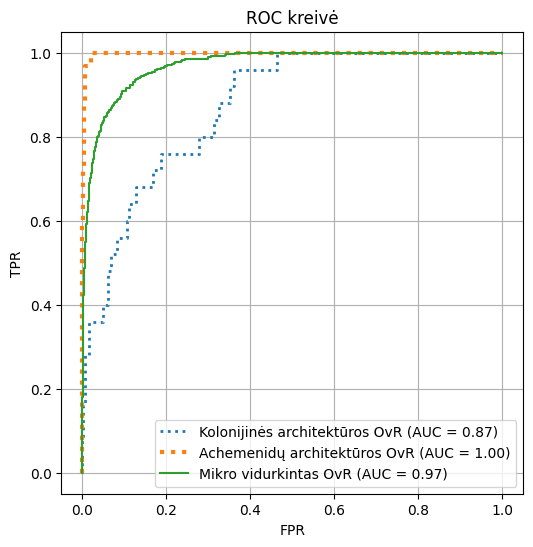

In [32]:
from sklearn.metrics import RocCurveDisplay

fig, ax = plt.subplots(figsize=(6, 6))
RocCurveDisplay.from_predictions(
    y_true_onehot[:, 11],
    prediction[:, 11],
    ax = ax,
    name="Kolonijinės architektūros OvR",
    linestyle=":",
    linewidth=2
)
RocCurveDisplay.from_predictions(
    y_true_onehot[:, 0],
    prediction[:, 0],
    ax = ax,
    name="Achemenidų architektūros OvR",
    linestyle=":",
    linewidth=3
)
RocCurveDisplay.from_predictions(
    y_true_onehot.ravel(),
    prediction.ravel(),
    ax = ax,
    name="Mikro vidurkintas OvR"
)
plt.axis("square")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC kreivė")
plt.legend()
plt.grid(True)
plt.show()

In [11]:
curve_points_per_class = dict()
labels = get_labels()

for class_index in range(25):
    y_true = y_true_onehot[:, class_index]
    pred = prediction[:, class_index]
    curve_points_per_class[labels[class_index]] = dict()
    curve_points_per_class[labels[class_index]]['x'] = list()
    curve_points_per_class[labels[class_index]]['y'] = list()
    
    for threshold in np.arange(0, 1, 0.01):
        tp = 0
        fn = 0
        fp = 0
        tn = 0
        
        for (y, p) in zip(y_true, pred):
            if y == 1 and p >= threshold:
                tp += 1
            if y == 1 and p < threshold:
                fn += 1
            if y == 0 and p >= threshold:
                fp += 1
            if y == 0 and p < threshold:
                tn += 1
        
        tpr = tp / (tp + fn)
        fpr = fp / (fp + tn)
        
        curve_points_per_class[labels[class_index]]['x'].append(fpr)
        curve_points_per_class[labels[class_index]]['y'].append(tpr)

print(curve_points_per_class['Colonial architecture'])

{'x': [1.0, 0.4003690036900369, 0.3025830258302583, 0.22509225092250923, 0.17896678966789667, 0.14760147601476015, 0.12915129151291513, 0.1014760147601476, 0.09225092250922509, 0.07749077490774908, 0.07380073800738007, 0.06826568265682657, 0.06088560885608856, 0.055350553505535055, 0.04981549815498155, 0.04797047970479705, 0.042435424354243544, 0.04059040590405904, 0.03690036900369004, 0.03505535055350553, 0.027675276752767528, 0.02214022140221402, 0.02214022140221402, 0.02029520295202952, 0.02029520295202952, 0.01845018450184502, 0.01845018450184502, 0.016605166051660517, 0.016605166051660517, 0.016605166051660517, 0.016605166051660517, 0.016605166051660517, 0.016605166051660517, 0.014760147601476014, 0.014760147601476014, 0.014760147601476014, 0.014760147601476014, 0.014760147601476014, 0.012915129151291513, 0.012915129151291513, 0.012915129151291513, 0.012915129151291513, 0.01107011070110701, 0.01107011070110701, 0.01107011070110701, 0.00922509225092251, 0.007380073800738007, 0.0073

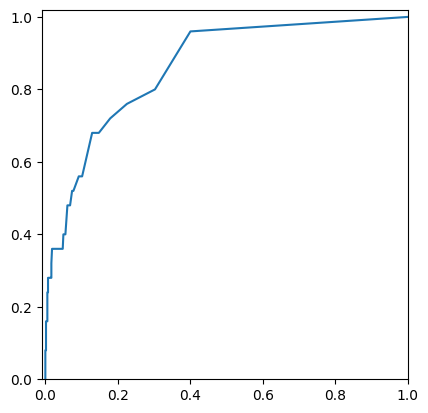

In [12]:

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(curve_points_per_class['Colonial architecture']['x'], curve_points_per_class['Colonial architecture']['y'])
ax.set_xbound(-0.01, 1.0)
ax.set_ybound(0.0, 1.02)
ax.set_aspect('equal')

# plt.plot(curve_points_per_class['Colonial architecture']['x'], curve_points_per_class['Colonial architecture']['y'])


In [112]:
tester.test_accuracy(prediction, tester.test_dataset)

Accuracy:  64.02
Top 5 accuracy:  92.59


In [31]:
results_by_label = tester.categorize_results_by_label(prediction, tester.test_dataset)

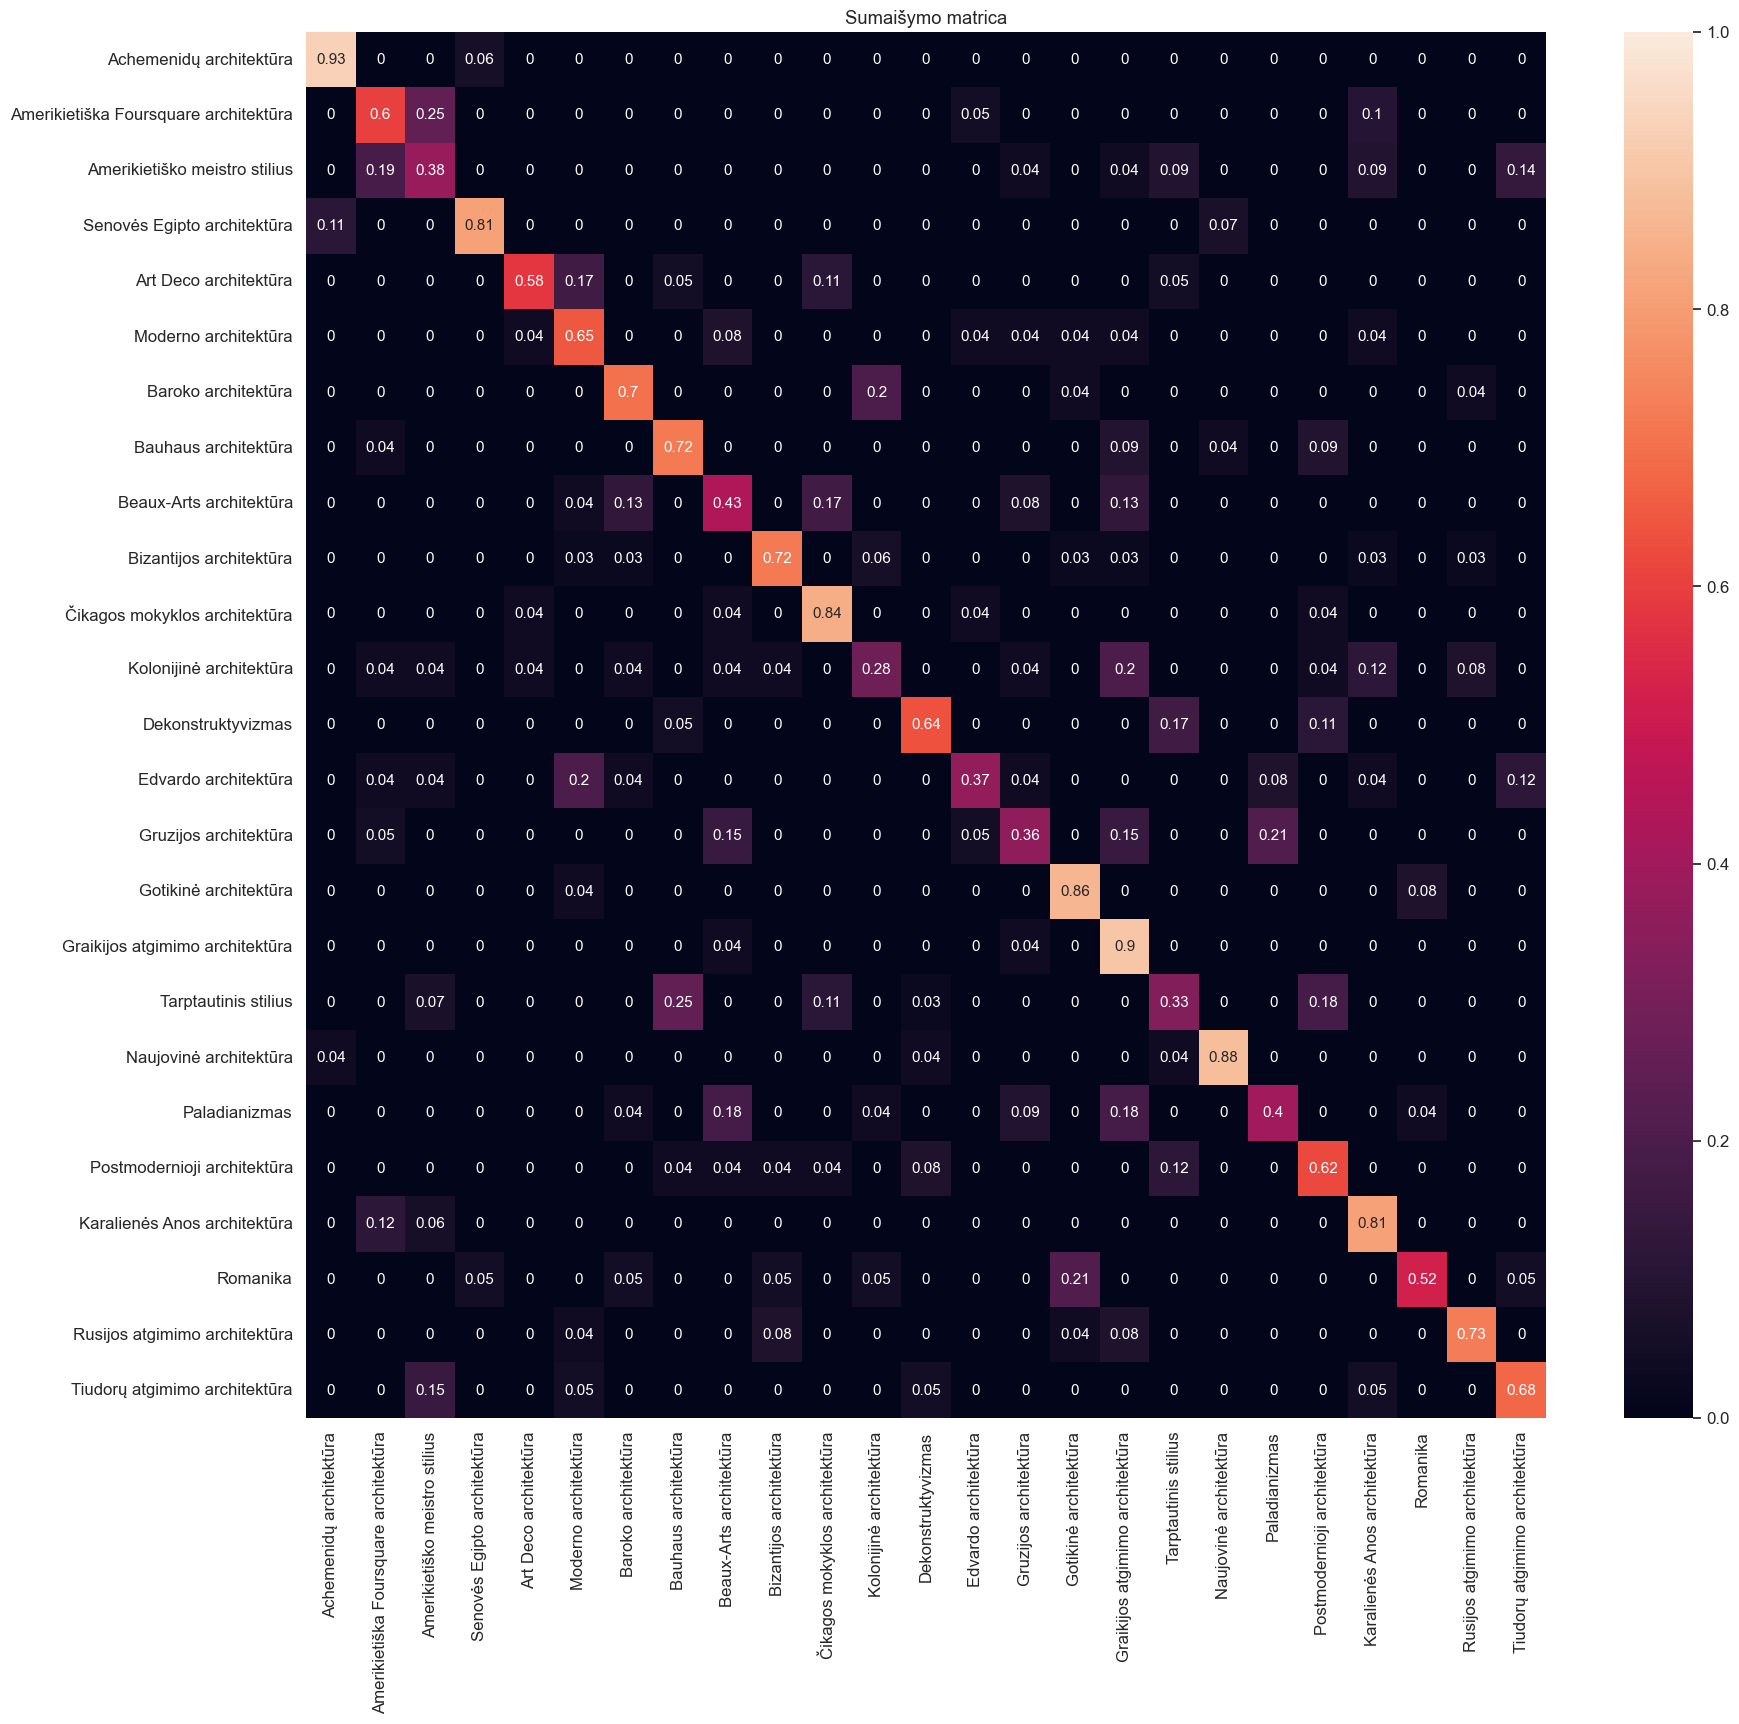

In [32]:
confusion_matrix = tester.plot_confusion_matrix(results_by_label)

In [8]:
class_confusion = list()

for (i, y) in enumerate(range(25)):
    column: np.ndarray = confusion_matrix[:, y]

    confusion = 0.0
    for x in column:
        if i == x:
            continue
        confusion += x

    class_confusion.append(confusion)

most_confused_value = 0.0
most_confused_label = 0
least_confused_value = 1000
least_confused_label = 0
for i, x in enumerate(class_confusion):
    if x > most_confused_value:
        most_confused_value = x
        most_confused_label = i
        
    if x < least_confused_value:
        least_confused_value = x
        least_confused_label = i
        
print("daugiausiai sumaišomas: ", tester.class_names_translated[most_confused_label])
print("mažiausiai sumaišomas:  ", tester.class_names_translated[least_confused_label])

[1.1400000000000001, 1.19, 1.19, 0.58, 0.94, 0.86, 0.86, 2.2, 1.16, 0.67, 0.9099999999999999, 0.69, 1.06, 0.29000000000000004, 0.5, 0.88, 1.3600000000000003, 0.33, 0.97, 1.11, 0.91, 1.13, 1.63, 1.2200000000000002, 0.8500000000000001]
daugiausiai sumaišomas:  Bauhaus architektūra
mažiausiai sumaišomas:   Edvardo architektūra


In [53]:
missed_results = tester.group_missed_results(results_by_label)

predicted:  Romanesque architecture
actual:  Edwardian architecture


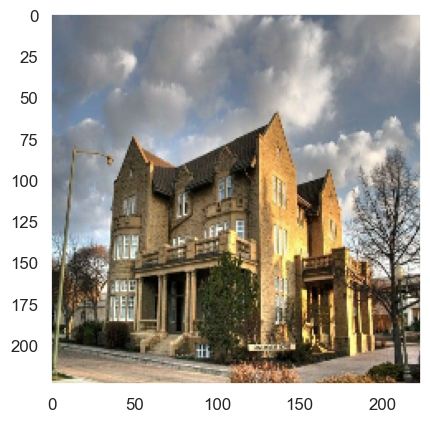

In [98]:
index = np.random.randint(0, len(missed_results))
res = missed_results[index]
image = res['image']
print('predicted: ', res['prediction_label'])
print('actual: ', res['correct_label'])
plt.grid(False)
plt.imshow(image)
pass

In [64]:
f, plot = plt.subplots(1, 2)

achemenid_image:np.ndarray = results_by_label['Achaemenid architecture'][np.random.randint(0, 10)]['image']
egypt_image:np.ndarray = results_by_label['Ancient Egyptian architecture'][np.random.randint(0, 10)]['image']

# scale image color channels to [0..1] from [0..255]
vfunc = np.vectorize(lambda t: t / 255)

achemenid_image = vfunc(achemenid_image)
egypt_image = vfunc(egypt_image)

plot[0].axis('off')
plot[0].grid(False)
plot[0].set_title('Achemenidų architektūra')
plot[0].imshow(achemenid_image)

plot[1].axis('off')
plot[1].grid(False)
plot[1].set_title('Senovės Egipto architektūra')
plot[1].imshow(egypt_image)
plt.show()

In [104]:
colonial_image:np.ndarray = results_by_label['Colonial architecture'][np.random.randint(0, 20)]['image']
greek_image:np.ndarray = results_by_label['Greek Revival architecture'][np.random.randint(0, 20)]['image']
queen_image:np.ndarray = results_by_label['Queen Anne architecture'][np.random.randint(0, 20)]['image']

# scale image color channels to [0..1] from [0..255]
vfunc = np.vectorize(lambda t: t / 255)

colonial_image = vfunc(colonial_image)
greek_image = vfunc(greek_image)
queen_image = vfunc(queen_image)

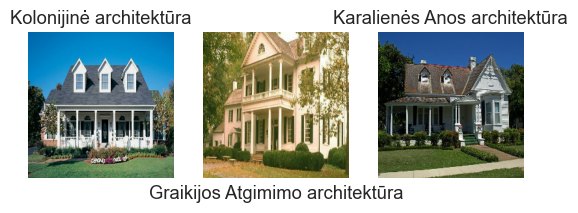

In [106]:
f, plot = plt.subplots(1, 3)

plot[0].axis('off')
plot[0].grid(False)
plot[0].set_title('Kolonijinė architektūra')
plot[0].imshow(colonial_image)

plot[1].axis('off')
plot[1].grid(False)
plot[1].set_title('Graikijos Atgimimo architektūra', y=-0.2)
plot[1].imshow(greek_image)

plot[2].axis('off')
plot[2].grid(False)
plot[2].set_title('Karalienės Anos architektūra')
plot[2].imshow(queen_image)
plt.show()